In [1]:
import os
import argparse
import time
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import sys

import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import einops
from einops import rearrange
import sklearn.metrics
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from monodepth2.networks import ResnetEncoder, DepthDecoder
import PIL.Image as pil

In [3]:
device = "cpu"
model_path = "/nethome/abati7/flash/Work/jat/"
encoder_path = os.path.join(model_path, "encoder.pth")
depth_decoder_path = os.path.join(model_path, "depth.pth")

In [4]:
encoder = ResnetEncoder(18, True)
loaded_dict_enc = torch.load(encoder_path, map_location=device)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)
encoder.to(device)
encoder.eval()

/nethome/abati7/flash/miniconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/nethome/abati7/flash/miniconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResnetEncoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [5]:
# extract the height and width of image that this model was trained with
feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']

In [6]:
depth_decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))
loaded_dict = torch.load(depth_decoder_path, map_location=device)
depth_decoder.load_state_dict(loaded_dict)
depth_decoder.to(device)
depth_decoder.eval()

DepthDecoder(
  (decoder): ModuleList(
    (0-1): 2 x ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (2-3): 2 x ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (4-5): 2 x ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (6): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      )
      (nonlin): ELU(alpha=1.0, inplace=True)
    )
    (7): ConvBlock(
      (conv): Conv3x3(
        (pad): ReflectionPad2d((1, 1, 1, 1)

In [7]:
# Load image and preprocess
image_path = "/nethome/abati7/flash/Data/gazefollow_extended/"
testImage = "train/00000080/00080697.jpg" #"test2/00000000/00000830.jpg"
image_path += testImage
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
input_image = input_image.resize((feed_width, feed_height), pil.LANCZOS)
input_image = transforms.ToTensor()(input_image).unsqueeze(0)

In [8]:
# PREDICTION
input_image = input_image.to(device)
features = encoder(input_image)
outputs = depth_decoder(features)

In [9]:
# PREDICTION
input_image = input_image.to(device)
features = encoder(input_image)
outputs = depth_decoder(features)
disp = outputs[("disp", 0)]
disp_resized = torch.nn.functional.interpolate(disp, (224, 224), mode="bilinear", align_corners=False)

In [10]:
disp_resized.shape

torch.Size([1, 1, 224, 224])

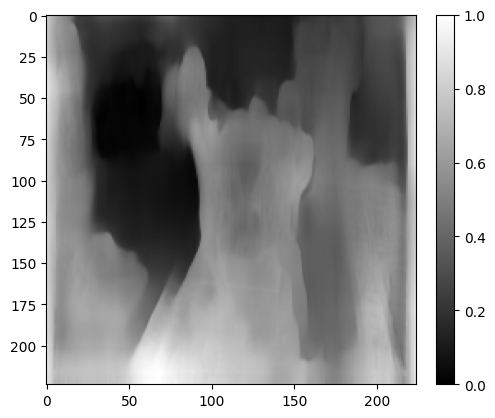

In [11]:
plt.figure(1)
data = disp_resized.detach().numpy().squeeze()
data = (data-data.min())/(data.max()-data.min())
img = plt.imshow(data, cmap='gray')

# Add a colorbar
cbar = plt.colorbar(img, fraction=0.046, pad=0.04)

plt.show()

In [12]:
print(disp_resized.detach().numpy().min(),disp_resized.detach().numpy().max())

0.014968401 0.18519948


In [13]:
#transforms for Gaze360
def prepReadInput(query, bounders=None):
    img = cv2.imread(query)
    ogimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if bounders != None:
        img = getCrop(ogimg, bounders)
    plt.imshow(img)
    return ogimg, ogimg.shape, preprocessing(img)

def getCrop(image, bounders):
    xmin, ymin, xmax, ymax = bounders
    img = image[int(ymin):int(ymax)+1,int(xmin):int(xmax)+1] #429.0	2.0	509.0	80.0
    return img


def spherical2cartesial(x):
    print(x*180/torch.pi)
    output = torch.zeros(x.size(0),3)
    output[:,2] = -torch.cos(x[:,1])*torch.cos(x[:,0])
    output[:,0] = torch.cos(x[:,1])*torch.sin(x[:,0])
    output[:,1] = torch.sin(x[:,1])
    return output
preprocessing = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224), antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

In [14]:
sys.path.append('/nethome/abati7/flash/Work/jat/gaze360/code/')
from model import GazeLSTM
model = GazeLSTM()
model = nn.DataParallel(model).to(device)
checkpoint = torch.load('models/gaze360_model.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
model.eval()

DataParallel(
  (module): GazeLSTM(
    (base_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

In [15]:
test = pd.read_csv("/nethome/abati7/flash/Data/train_annotations_release_angles.txt", sep=",")
curr = test[test['image_path']==testImage]
curr

,Unnamed: 0,image_path,id,body_bbox_x,body_bbox_y,body_bbox_width,body_bbox_height,eye_x,eye_y,gaze_x,gaze_y,head_bbox_x_min,head_bbox_y_min,head_bbox_x_max,head_bbox_y_max,in_or_out,meta,origin,angle2d_rad,angle2d_deg
0,0,train/00000080/00080697.jpg,1,0.29,0.11,0.68,0.89,0.41273,0.2143,0.51091,0.31133,279.6,64.2,331.4,139.8,1,places_top,m/martial_arts_gym/gsun_34b947519c2cb1b79f302e...,5.69518,326.309783


In [16]:
for x in test['image_path']:
    print(x)
    break

train/00000080/00080697.jpg


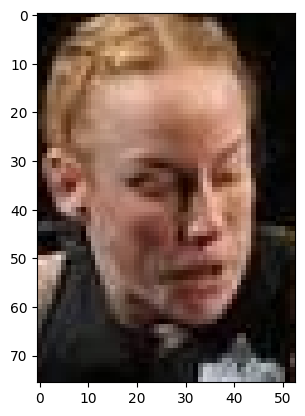

In [17]:
ogimg, orig_shape, orig_img = prepReadInput(image_path, bounders=curr.iloc[0][['head_bbox_x_min','head_bbox_y_min','head_bbox_x_max','head_bbox_y_max']].values.tolist())

In [18]:
img = torch.stack([orig_img]*7)
img.shape

torch.Size([7, 3, 224, 224])

In [19]:
with torch.no_grad():
    output_gaze, _ = model(img.view(1,7,3,224,224))
gaze_coords = spherical2cartesial(output_gaze)
print(gaze_coords)
gaze_coords[0,2] = -gaze_coords[0,2]
gaze_coords

tensor([[-45.6876, -34.3429]])
tensor([[-0.5908, -0.5641, -0.5768]])


tensor([[-0.5908, -0.5641,  0.5768]])

In [20]:
output_gaze

tensor([[-0.7974, -0.5994]])

In [21]:
def angle3dTo2d(yawpitch):
    yaw, pitch = yawpitch
    deg = np.arctan2(np.sin(pitch), -1*np.sin(yaw)*np.cos(pitch))
    deg = deg + (2*np.pi if deg < 0 else 0)
    return deg

angle_pred = angle3dTo2d(output_gaze.detach().numpy().squeeze())*180/np.pi
angle_pred

316.32244499215693

In [22]:
output_gaze.detach().numpy().squeeze()

array([-0.7973991, -0.5993959], dtype=float32)

In [23]:
def get_continuous_gaze_cone2d(head_center_point, gaze_angle, out_size=(64, 64), cone_angle=120):

    height, width = out_size
    B = len(gaze_angle)

    head_center_point = head_center_point.view(B, -1) #(B,2)
    gaze_angle_rad = torch.deg2rad(gaze_angle)
    # gaze_vector = torch.stack([torch.cos(gaze_angle_rad), torch.sin(gaze_angle_rad)]).unsqueeze(dim=0)
    gaze_vector = torch.stack([-torch.sin(gaze_angle_rad), torch.cos(gaze_angle_rad)],dim=1).view(B, -1) #
    

    eye_coords = ( #eye_coords must have an additional dimension which represents depth, so might need to cast to int
        (
            head_center_point
            * torch.tensor([height, width], device=head_center_point.device)
        )
        .unsqueeze(1)
        .unsqueeze(1)
    )
    print(eye_coords)
    gaze_coords = ( #defined by gaze vector which is provided by gaze direction predictor
        (
            #change:(head_center_point + gaze_vector)
            #* torch.tensor([height, width], device=head_center_point.device)
            
            #to:
            (gaze_vector)
        )
        .unsqueeze(1)
        .unsqueeze(1)
    )
    print(gaze_coords)
    pixel_mat = ( #modify this so there is another dimension [B,H,W,2+1], where +1 = depth map integration
        torch.stack(
            torch.meshgrid(
                [torch.arange(1, height + 1), torch.arange(1, width + 1)], indexing="ij"
            ),
            dim=-1,
        )
        .unsqueeze(0)
        .repeat(head_center_point.shape[0], 1, 1, 1)
        .to(head_center_point.device)
    )
    print(pixel_mat.shape)

    #changed gaze_coords - eye_coords to just gaze_coords
    dot_prod = torch.sum((pixel_mat - eye_coords) * (gaze_coords), dim=-1)
    gaze_vector_norm = torch.sqrt(torch.sum((gaze_coords) ** 2, dim=-1))
    pixel_mat_norm = torch.sqrt(torch.sum((pixel_mat - eye_coords) ** 2, dim=-1))

    out = dot_prod / (gaze_vector_norm * pixel_mat_norm)
    mins = torch.min(out.view(B, -1), dim=1).values
    maxs = torch.max(out.view(B, -1), dim=1).values
    scaled = (out - mins) / (maxs-mins)

    return scaled

def get_continuous_gaze_cone3d(head_center_point, gaze_vector, depth_maps, out_sizes):
    """
    head_center_point: tensor(1, 2)
    gaze_vector: tensor(1, 3)
    depth_maps: tensor(1, H, W)
    out_sizes: list(1, 2)
    """
    height, width = out_sizes
    #do i really need to batchify all of this?
    #just assume batch_size=B=1
    B = len(gaze_vector)

    eye_coords = ( #eye_coords must have an additional dimension which represents depth, so might need to cast to int
        (
            head_center_point
            * torch.tensor([out_sizes])
        )
        .int()
    )

    print(f"eye_coords int, {eye_coords}, shape: {eye_coords.shape}")
    head_center_point_depth = depth_maps[0, eye_coords[0,0], eye_coords[0,1]]
    print(f"depth of eye_coords, {head_center_point_depth}")
    eye_coords = torch.cat((eye_coords.float()/torch.tensor([out_sizes]), head_center_point_depth.unsqueeze(-1).unsqueeze(-1)),dim=-1)
    print(f"eye_coords float, {eye_coords}, shape: {eye_coords.shape}")
    gaze_coords = ( #defined by gaze vector which is provided by gaze direction predictor
        (
            #change:(head_center_point + gaze_vector)
            #* torch.tensor([height, width], device=head_center_point.device)
            
            #to:
            (gaze_vector)
        )
        .unsqueeze(1)
        .unsqueeze(1)
    )
    gaze_coords[0,0,0,[0,1]] = -gaze_coords[0,0,0,[1,0]] #swap x and y (rows=y, columns=x) and negate their axes
    print(f"gaze_coords, {gaze_coords}, shape: {gaze_coords.shape}")
    pixel_mat = (
        torch.stack(
            torch.meshgrid(
                [torch.arange(0, 1, 1/height), torch.arange(0, 1, 1/width)], indexing="ij"
            ),
            dim=-1,
        )
        .unsqueeze(0)
        .repeat(head_center_point.shape[0], 1, 1, 1)
        .to(head_center_point.device)
    )
    pixel_mat = torch.cat((pixel_mat, depth_maps.unsqueeze(-1)), dim=-1)
    print(f"pixel_mat shape: {pixel_mat.shape}")

    #changed gaze_coords - eye_coords to just gaze_coords
    dot_prod = torch.sum((pixel_mat - eye_coords) * (gaze_coords), dim=-1)
    gaze_vector_norm = torch.sqrt(torch.sum((gaze_coords) ** 2, dim=-1))
    pixel_mat_norm = torch.sqrt(torch.sum((pixel_mat - eye_coords) ** 2, dim=-1))
    out = dot_prod / (gaze_vector_norm * pixel_mat_norm)

    out = torch.nan_to_num(out)
    mins = torch.min(out.view(B, -1), dim=1).values
    maxs = torch.max(out.view(B, -1), dim=1).values
    print(maxs,mins)
    scaled = (out - mins) / (maxs-mins)

    return scaled

In [24]:
depthMapTrial = torch.zeros(orig_shape[:2])
depthMapTrial += 0.1
depthMapTrial[223:274] += 100
eyes = curr.iloc[0][['eye_y','eye_x']].values.tolist()
cone = get_continuous_gaze_cone3d(torch.tensor([eyes]),
                           gaze_coords, 
                           torch.from_numpy(data).unsqueeze(0),  #torch.from_numpy(data)
                           (224,224)#    orig_shape[:2]
                           )

cone2 = get_continuous_gaze_cone2d(torch.tensor([eyes]),
                           torch.tensor([angle_pred]), 
                           orig_shape[:2]
                           ).detach().numpy().squeeze()
cone = cone.detach().numpy().squeeze()

eye_coords int, tensor([[48, 92]], dtype=torch.int32), shape: torch.Size([1, 2])
depth of eye_coords, 0.4684208631515503
eye_coords float, tensor([[0.2143, 0.4107, 0.4684]]), shape: torch.Size([1, 3])
gaze_coords, tensor([[[[0.5641, 0.5908, 0.5768]]]]), shape: torch.Size([1, 1, 1, 3])
pixel_mat shape: torch.Size([1, 224, 224, 3])
tensor([0.9878]) tensor([-1.0000])
tensor([[[[109.7216, 313.2621]]]], dtype=torch.float64)
tensor([[[[0.6906, 0.7232]]]], dtype=torch.float64)
torch.Size([1, 512, 759, 2])


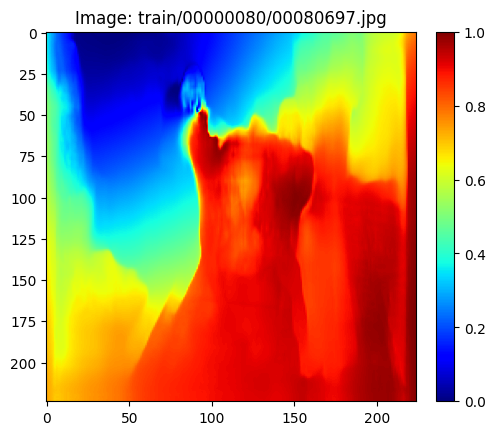

In [25]:
plt.figure(1)
img = plt.imshow(cone, cmap='jet')
cbar = plt.colorbar(img, fraction=0.046, pad=0.04)

# img = plt.imshow(ogimg, alpha=0.2)

# Add a colorbar

plt.title(f'Image: {testImage}')
plt.show()

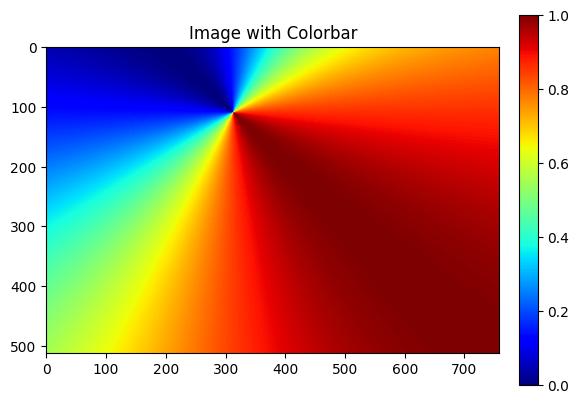

In [26]:
plt.figure(1)
img = plt.imshow(cone2, cmap='jet')

# Add a colorbar
cbar = plt.colorbar(img, fraction=0.046, pad=0.04)

plt.title('Image with Colorbar')
plt.show()

In [27]:
cone

array([[0.36295265, 0.33756378, 0.31491292, ..., 0.7641028 , 0.77175194,
        0.7796598 ],
       [0.3646168 , 0.33950546, 0.31661415, ..., 0.767328  , 0.77474844,
        0.7827311 ],
       [0.36502698, 0.33969107, 0.3163039 , ..., 0.77118284, 0.778203  ,
        0.78624916],
       ...,
       [0.7341864 , 0.7272361 , 0.7224255 , ..., 0.98209417, 0.98642135,
        0.9897989 ],
       [0.73529124, 0.72825044, 0.723294  , ..., 0.98184514, 0.98629326,
        0.98956436],
       [0.7359596 , 0.7288936 , 0.7240281 , ..., 0.9814876 , 0.985972  ,
        0.98920065]], dtype=float32)

In [28]:
cone2

array([[0.04494975, 0.04474334, 0.0445362 , ..., 0.76905769, 0.76927671,
        0.76949473],
       [0.04554398, 0.04533777, 0.04513083, ..., 0.7699535 , 0.77017044,
        0.77038638],
       [0.04614311, 0.04593714, 0.04573042, ..., 0.77084902, 0.77106386,
        0.77127773],
       ...,
       [0.5498277 , 0.55060125, 0.55137656, ..., 0.99979887, 0.99978268,
        0.99976591],
       [0.5504295 , 0.55120249, 0.55197722, ..., 0.99981609, 0.99980059,
        0.99978451],
       [0.55102937, 0.55180178, 0.55257593, ..., 0.9998325 , 0.99981769,
        0.99980229]])

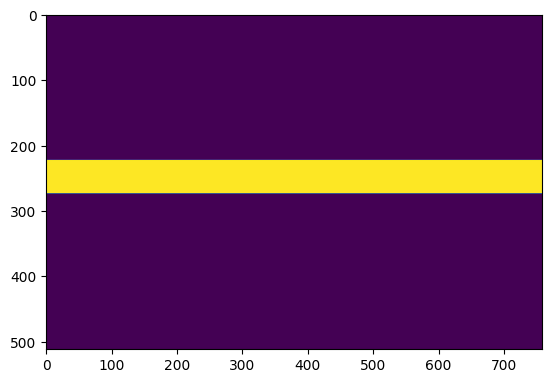

In [29]:
depthMapTrial = torch.zeros(orig_shape[:2])
depthMapTrial[223:274] = 2
depthMapTrial -= 1

plt.imshow(depthMapTrial)

In [30]:
torch.tensor([[0.258000, 0.606667]]) * torch.tensor([500,375])

tensor([[129.0000, 227.5001]])

In [31]:
a = torch.tensor([[[1,2],[1,2],[1,2]],[[1,2],[1,2],[1,2]]])
b = torch.tensor([[3,4,5],[6,7,8]])
torch.cat((a,b.unsqueeze(-1)),dim=-1)

tensor([[[1, 2, 3],
         [1, 2, 4],
         [1, 2, 5]],

        [[1, 2, 6],
         [1, 2, 7],
         [1, 2, 8]]])

In [31]:
# a = pd.read_csv("/nethome/abati7/flash/Data/gazefollow_extended/traind+a.csv")
# b = a['image_path'].str.replace("/",'-').str.split(".").str[0]+".npy"
# a['depthLocationNames'] = b

In [34]:
# a = a.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

In [35]:
# a.to_csv("/nethome/abati7/flash/Data/gazefollow_extended/traind+aFINAL.csv", index=False)

In [32]:
a = pd.read_csv("/nethome/abati7/flash/Data/gazefollow_extended/oldCSVs/test2d+aFINAL.csv")

In [33]:
a[a['image_path'] == "test2/00000000/00000001.jpg"][["eye_x","eye_y"]]

,eye_x,eye_y
0,0.258,0.606667
1,0.258,0.606667
2,0.258,0.606667
3,0.258,0.606667
4,0.258,0.606667
5,0.258,0.606667
6,0.258,0.606667
7,0.258,0.606667
8,0.258,0.606667
9,0.258,0.606667


In [18]:
i=100
t = np.load("/nethome/abati7/flash/Data/gazefollow_extended/traindepth/"+a.iloc[i]['depthLocationNames'])
a.iloc[i]['depthLocationNames']

'train-00000072-00072708.npy'

In [8]:
asdf =a.iloc[0]
asdf[['eye_x','eye_y']].to_numpy()

array([0.41273, 0.2143], dtype=object)

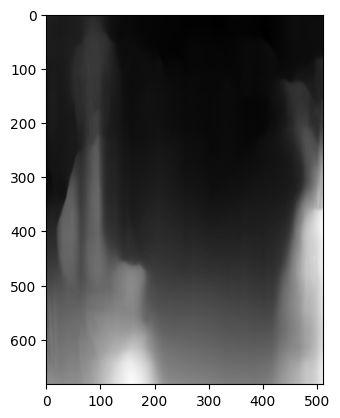

In [20]:
plt.imshow(t, cmap="gray")

In [17]:
a = torch.ones((5,3,224,224))
b = torch.ones((5,224,224))*2
c = torch.ones((5,224,224))*3
torch.cat((a,b.unsqueeze(1),c.unsqueeze(1)),1).shape

torch.Size([5, 5, 224, 224])

In [8]:
a = np.ones((2))
a[np.newaxis, :]

array([[1., 1.]])

In [2]:
from resnetish import Bottleneck
class Horanyi(nn.Module):
    def __init__(self, block = Bottleneck, layers_scene = [3, 4, 6, 3, 2], layers_face = [3, 4, 6, 3, 2]):
        super().__init__()
        self.inplanes_scene = 64
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #Resnet
        #later include NL blocks in layer2_scene and layer3_scene
        self.conv1_scene = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1_scene = nn.BatchNorm2d(64)
        self.layer1_scene = self._make_layer_scene(block, 64, layers_scene[0])
        self.layer2_scene = self._make_layer_scene(block, 128, layers_scene[1], stride=2)
        self.layer3_scene = self._make_layer_scene(block, 256, layers_scene[2], stride=2)
        self.layer4_scene = self._make_layer_scene(block, 512, layers_scene[3], stride=2)
        self.layer5_scene = self._make_layer_scene(block, 256, layers_scene[4], stride=1) # additional to resnet50

        # encoding for saliency
        self.compress_conv1 = nn.Conv2d(1024, 512, kernel_size=1, stride=1, padding=0, bias=False) #used to be 2048, 1024
        self.compress_bn1 = nn.BatchNorm2d(512) #1024
        self.compress_conv2 = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0, bias=False) #used to be 1024, 512
        self.compress_bn2 = nn.BatchNorm2d(512)

        # decoding
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2)
        self.deconv_bn1 = nn.BatchNorm2d(256)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2)
        self.deconv_bn2 = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2)
        self.deconv_bn3 = nn.BatchNorm2d(1)
        self.conv4 = nn.Conv2d(1, 1, kernel_size=1, stride=1)


    def _make_layer_scene(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes_scene != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes_scene, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes_scene, planes, stride, downsample))
        self.inplanes_scene = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes_scene, planes))

        return nn.Sequential(*layers)
        
    def forward(self, imgInputs):
        """
        Input:
            img: concatenated features [r,g,b,d,fov] - tensor[B, 5, 224, 224]

        Returns: 
            outputAngles: (B, 1)
        """
        im = self.conv1_scene(imgInputs)
        im = self.bn1_scene(im)
        im = self.relu(im)
        im = self.maxpool(im)
        im = self.layer1_scene(im)
        im = self.layer2_scene(im)
        im = self.layer3_scene(im)
        im = self.layer4_scene(im)
        scene_feat = self.layer5_scene(im)


        encoding = self.compress_conv1(scene_feat)
        encoding = self.compress_bn1(encoding)
        encoding = self.relu(encoding)
        encoding = self.compress_conv2(encoding)
        encoding = self.compress_bn2(encoding)
        encoding = self.relu(encoding)


        x = self.deconv1(encoding)
        x = self.deconv_bn1(x)
        x = self.relu(x)
        
        x = self.deconv2(x)
        x = self.deconv_bn2(x)
        x = self.relu(x)

        x = self.deconv3(x)
        x = self.deconv_bn3(x)
        x = self.relu(x)

        x = self.conv4(x)

In [3]:
mod = Horanyi()

In [7]:
mod(torch.randn((2,5,224,224)))

In [11]:
total = 0
for x in mod.parameters():
    total += np.prod(list(x.size()))
total

30376261